In [1]:
%matplotlib inline

import math

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd

import statsmodels.formula.api as smf
import statsmodels

import seaborn as sn

In [2]:
# read in Inside Airbnb dataframe
df_2020 = pd.read_csv('2020IA.csv',low_memory=False)
df_2022 = pd.read_csv('2022IA.csv',low_memory=False)

In [3]:
# pick the columns that we need
df_2020_pick = df_2020.loc[:,['id', 'price', 'number_of_reviews_ltm','reviews_per_month']]
df_2022_pick = df_2022.loc[:,['id', 'room_type', 'price','longitude', 'latitude', 'minimum_nights', 'reviews_per_month']]

In [12]:
# rename the columns
df_2020_rename = df_2020_pick.rename(columns = {'price':'price_2020',
                                                'number_of_reviews_ltm':'number_of_reviews_ltm_2020',
                                                'reviews_per_month':'reviews_per_month_2020'})
df_2022_rename = df_2022_pick.rename(columns = {'price':'price_2022',
                                                'reviews_per_month':'reviews_per_month_2022'})
print(df_2020_rename.columns)
print(df_2022_rename.columns)

Index(['id', 'price_2020', 'number_of_reviews_ltm_2020',
       'reviews_per_month_2020'],
      dtype='object')
Index(['id', 'room_type', 'price_2022', 'longitude', 'latitude',
       'minimum_nights', 'reviews_per_month_2022'],
      dtype='object')


In [13]:
# join dataframes
df = pd.merge(df_2020_rename, df_2022_rename, how='inner', on=['id'])

In [14]:
#delete $ and change datatype
df['price_2020'] = df['price_2020'].mask(df['price_2020'].str.contains('\,')==True,df['price_2020'].str.replace(',',''))
df['price_2020'] = df['price_2020'].str.split('$').str[1]
df['price_2020'] = df['price_2020'].astype('float64')
#df['number_of_reviews_ltm_2020'] = df['number_of_reviews_ltm_2020'].astype('float64')
#df['reviews_per_month_2020'] = df['reviews_per_month_2020'].astype('float64')
df.dtypes

id                            float64
price_2020                    float64
number_of_reviews_ltm_2020    float64
reviews_per_month_2020        float64
room_type                      object
price_2022                      int64
longitude                     float64
latitude                      float64
minimum_nights                  int64
reviews_per_month_2022        float64
dtype: object

In [15]:
# data cleaning
df['reviews_per_month_2020'] = np.nan_to_num(df['reviews_per_month_2020'])
df['reviews_per_month_2022'] = np.nan_to_num(df['reviews_per_month_2022'])
df_cleaned = df[
    (df["number_of_reviews_ltm_2020"] != 0) & 
    (df["reviews_per_month_2020"] != 0) & 
    (df["reviews_per_month_2022"] != 0) & 
    (df["minimum_nights"] <= 5)]

In [16]:
# read in London sites dataframe
df_sites = pd.read_csv('vva_site_listings_London_2021_02.csv')

In [17]:
# rename site columns
df_sites_rename = df_sites.rename(columns = {'Visitors 2020':'visitors_2020','Visitors 2021':'visitors_2021'})

In [18]:
# pick the columns that we need
df_sites_pick = df_sites_rename.loc[:,['Longitude','Latitude', 'visitors_2020','visitors_2021']]
print(df_sites_pick.head())

   Longitude   Latitude  visitors_2020 visitors_2021
0  -0.295909  51.479362        1222956     1,963,171
1  -0.176389  51.496111        1296763     1,571,413
2  -0.126944  51.519444        1275466     1,327,120
3  -0.099400  51.507600        1431704     1,156,037
4  -0.117194  51.511028         724310       984,978


In [19]:
df_sites_pick['visitors_2021'] = df_sites_pick['visitors_2021'].str.replace('$','', regex=True).replace(',','', regex=True).astype('float64')
df_sites_pick['visitors_2020'] = df_sites_pick['visitors_2020'].astype('float64')

In [21]:
# Add index number
df_cleaned.insert(0, 'house_index', range(0, len(df_cleaned)))
df_sites_pick.insert(0, 'site_index', range(0, len(df_sites_pick)))
print(df_cleaned.head())
print(df_sites_pick.head())

   house_index       id  price_2020  number_of_reviews_ltm_2020  \
0            0  15400.0        75.0                         3.0   
1            1  17402.0       208.0                         1.0   
4            2  33332.0        65.0                         1.0   
5            3  36299.0       195.0                         4.0   
6            4  36660.0        72.0                        19.0   

   reviews_per_month_2020        room_type  price_2022  longitude  latitude  \
0                    0.68  Entire home/apt          75   -0.16813  51.48780   
1                    0.37  Entire home/apt         307   -0.14094  51.52195   
4                    0.05     Private room          65   -0.32554  51.46416   
5                    0.64  Entire home/apt         195   -0.28086  51.48085   
6                    4.36     Private room          72   -0.16057  51.58478   

   minimum_nights  reviews_per_month_2022  
0               3                    0.60  
1               4                 

In [23]:
#Dealing with Geo Data of sites

gdf_houses = gpd.GeoDataFrame(geometry=gpd.points_from_xy(df_cleaned.longitude, df_cleaned.latitude, crs='epsg:4326'))
gdf_houses = gdf_houses.geometry.to_crs('epsg:27700')
print(gdf_houses.head())

gdf_sites = gpd.GeoDataFrame(geometry=gpd.points_from_xy(df_sites_pick.Longitude, df_sites_pick.Latitude, crs='epsg:4326'))
gdf_sites = gdf_sites.geometry.to_crs('epsg:27700')
print(gdf_sites.head())

0    POINT (527284.576 178129.679)
1    POINT (529075.790 181974.865)
2    POINT (516416.338 175239.086)
3    POINT (519476.347 177167.001)
4    POINT (527538.280 188927.439)
Name: geometry, dtype: geometry
0    POINT (518435.241 176977.100)
1    POINT (526688.169 179039.579)
2    POINT (530053.870 181720.949)
3    POINT (531998.990 180453.132)
4    POINT (530754.373 180802.421)
Name: geometry, dtype: geometry


In [24]:
# calculate number of sites aroud houses and the distance between them
list1 = []
list2 = []
list3 = []
for i in range(0,len(gdf_houses)):
    #(x1,y1) is the coordinate of houses
    x1=gdf_houses.x[i]
    y1=gdf_houses.y[i]
    r=1000 #radius 1km
    count=0
    for j in range(0,len(gdf_sites)):
        #(x2,y2) is the coordinate of sites
        x2=gdf_sites.x[j]
        y2=gdf_sites.y[j]
        d=pow(pow(x1-x2,2)+pow(y1-y2,2),0.5)
        if d<r:
            count+=1

            list1.append(i)
            list2.append(j)
            list3.append(d)
            df_dis = pd.DataFrame({'house_index':list1,'site_index':list2,'d':list3})
print(df_dis.head())

   house_index  site_index           d
0            0           6  991.456024
1            0          28  484.940720
2            1          41  517.875515
3            1          51  434.722553
4            3          36  138.253958


In [49]:
# final dataframe
df_dis_houses = pd.merge(df_dis, df_cleaned, how='left', on=['house_index'])
df_dis_houses_sites = pd.merge(df_dis_houses, df_sites_pick, how='left', on=['site_index'])
df_dis_houses_sites_pick = df_dis_houses_sites.loc[:,['house_index', 'site_index', 'd',
                                                      'price_2020','price_2022','number_of_reviews_ltm_2020',
                                                      'reviews_per_month_2020','reviews_per_month_2022',
                                                      'visitors_2020','visitors_2021']]
print(df_dis_houses_sites_pick.head())

   house_index  site_index           d  price_2020  price_2022  \
0            0           6  991.456024        75.0          75   
1            0          28  484.940720        75.0          75   
2            1          41  517.875515       208.0         307   
3            1          51  434.722553       208.0         307   
4            3          36  138.253958       195.0         195   

   number_of_reviews_ltm_2020  reviews_per_month_2020  reviews_per_month_2022  \
0                         3.0                    0.68                    0.60   
1                         3.0                    0.68                    0.60   
2                         1.0                    0.37                    0.34   
3                         1.0                    0.37                    0.34   
4                         4.0                    0.64                    0.64   

   visitors_2020  visitors_2021  
0       872750.0       857742.0  
1        37965.0        53314.0  
2         6848

In [50]:
#find min(d) and cnt(sites)
df_index_d = df_dis_houses_sites_pick.loc[:,['house_index','d']]
df_min_d = df_index_d.groupby(['house_index'],as_index=False).min()
df_cnt_sites = df_index_d.groupby(['house_index'],as_index=False).count()
df_cnt_sites_rename = df_cnt_sites.rename(columns = {'d':'cnt'})


df_min_d_merge = pd.merge(df_dis_houses_sites_pick, df_min_d, how='right', on=['d'])
df_min_d_merge_rename = df_min_d_merge.rename(columns = {'house_index_x':'house_index'})
df_cnt_merge = pd.merge(df_min_d_merge_rename, df_cnt_sites_rename, how='right', on=['house_index'])


df_final = df_cnt_merge.loc[:,['d', 'price_2020', 'price_2022', 'number_of_reviews_ltm_2020',
                               'reviews_per_month_2020', 'reviews_per_month_2022',
                               'visitors_2020','visitors_2021','cnt']]
print(df_final.head())

            d  price_2020  price_2022  number_of_reviews_ltm_2020  \
0  484.940720        75.0          75                         3.0   
1  434.722553       208.0         307                         1.0   
2  138.253958       195.0         195                         4.0   
3  806.850772        42.0         150                         2.0   
4  658.957941        69.0          79                         4.0   

   reviews_per_month_2020  reviews_per_month_2022  visitors_2020  \
0                    0.68                    0.60        37965.0   
1                    0.37                    0.34           40.0   
2                    0.64                    0.64        22603.0   
3                    0.63                    0.54         3072.0   
4                    0.79                    0.65      1431704.0   

   visitors_2021  cnt  
0        53314.0    2  
1         2000.0    2  
2        20512.0    1  
3         4159.0    1  
4      1156037.0    3  


In [51]:
# print the shape of the DataFrame
df_final.shape

(4441, 9)

In [52]:
#Data standardisation

from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()

df_standardised = df_final.copy()
for c in df_final.columns.values:
    df_standardised[c] = mms.fit_transform(df_final[c].values.reshape(-1,1))
df_standardised.head()

,d,price_2020,price_2022,number_of_reviews_ltm_2020,reviews_per_month_2020,reviews_per_month_2022,visitors_2020,visitors_2021,cnt
0,0.474289,0.003329,0.003869,0.005814,0.032549,0.023043,0.026517,0.027131,0.090909
1,0.423030,0.010470,0.017678,0.000000,0.017026,0.012714,0.000028,0.000992,0.090909
2,0.120418,0.009772,0.011011,0.008721,0.030546,0.024632,0.015787,0.010422,0.000000
3,0.802869,0.001557,0.008333,0.002907,0.030045,0.020660,0.002146,0.002092,0.000000
4,0.651912,0.003007,0.004107,0.008721,0.038057,0.025030,1.000000,0.588851,0.181818


<AxesSubplot:xlabel='cnt', ylabel='visitors_2021'>

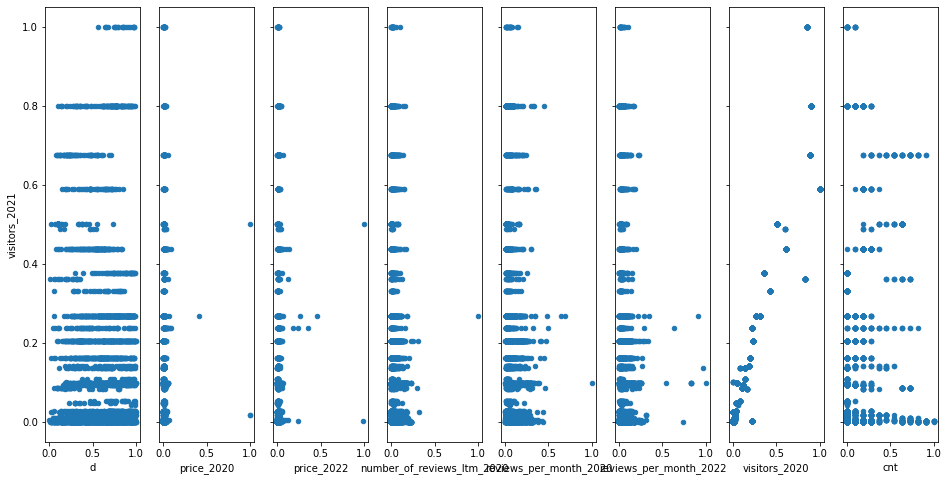

In [53]:
# visualize the relationship between the features and the response using scatterplots
fig, axs = plt.subplots(1, 8, sharey=True)
df_standardised.plot(kind='scatter', x='d', y='visitors_2021', ax=axs[0], figsize=(16, 8))
df_standardised.plot(kind='scatter', x='price_2020', y='visitors_2021', ax=axs[1])
df_standardised.plot(kind='scatter', x='price_2022', y='visitors_2021', ax=axs[2])
df_standardised.plot(kind='scatter', x='number_of_reviews_ltm_2020', y='visitors_2021', ax=axs[3])
df_standardised.plot(kind='scatter', x='reviews_per_month_2020', y='visitors_2021', ax=axs[4])
df_standardised.plot(kind='scatter', x='reviews_per_month_2022', y='visitors_2021', ax=axs[5])
df_standardised.plot(kind='scatter', x='visitors_2020', y='visitors_2021', ax=axs[6])
df_standardised.plot(kind='scatter', x='cnt', y='visitors_2021', ax=axs[7])

In [54]:
df_standardised.corr()

,d,price_2020,price_2022,number_of_reviews_ltm_2020,reviews_per_month_2020,reviews_per_month_2022,visitors_2020,visitors_2021,cnt
d,1.000000,-0.008681,-0.026139,-0.066597,-0.047365,-0.012238,-0.050751,0.009878,-0.529954
price_2020,-0.008681,1.000000,0.129939,-0.051148,-0.060773,-0.047025,0.016716,0.016512,0.025775
price_2022,-0.026139,0.129939,1.000000,-0.069727,-0.066625,-0.056865,0.038124,0.027456,0.086881
number_of_reviews_ltm_2020,-0.066597,-0.051148,-0.069727,1.000000,0.836122,0.650642,-0.057437,-0.061067,0.013411
reviews_per_month_2020,-0.047365,-0.060773,-0.066625,0.836122,1.000000,0.742786,-0.019683,-0.022189,0.002405
reviews_per_month_2022,-0.012238,-0.047025,-0.056865,0.650642,0.742786,1.000000,-0.030383,-0.025614,0.012632
visitors_2020,-0.050751,0.016716,0.038124,-0.057437,-0.019683,-0.030383,1.000000,0.962047,0.249574
visitors_2021,0.009878,0.016512,0.027456,-0.061067,-0.022189,-0.025614,0.962047,1.000000,0.144077
cnt,-0.529954,0.025775,0.086881,0.013411,0.002405,0.012632,0.249574,0.144077,1.000000


Text(0.5, 1.0, 'Correlation Matrix')

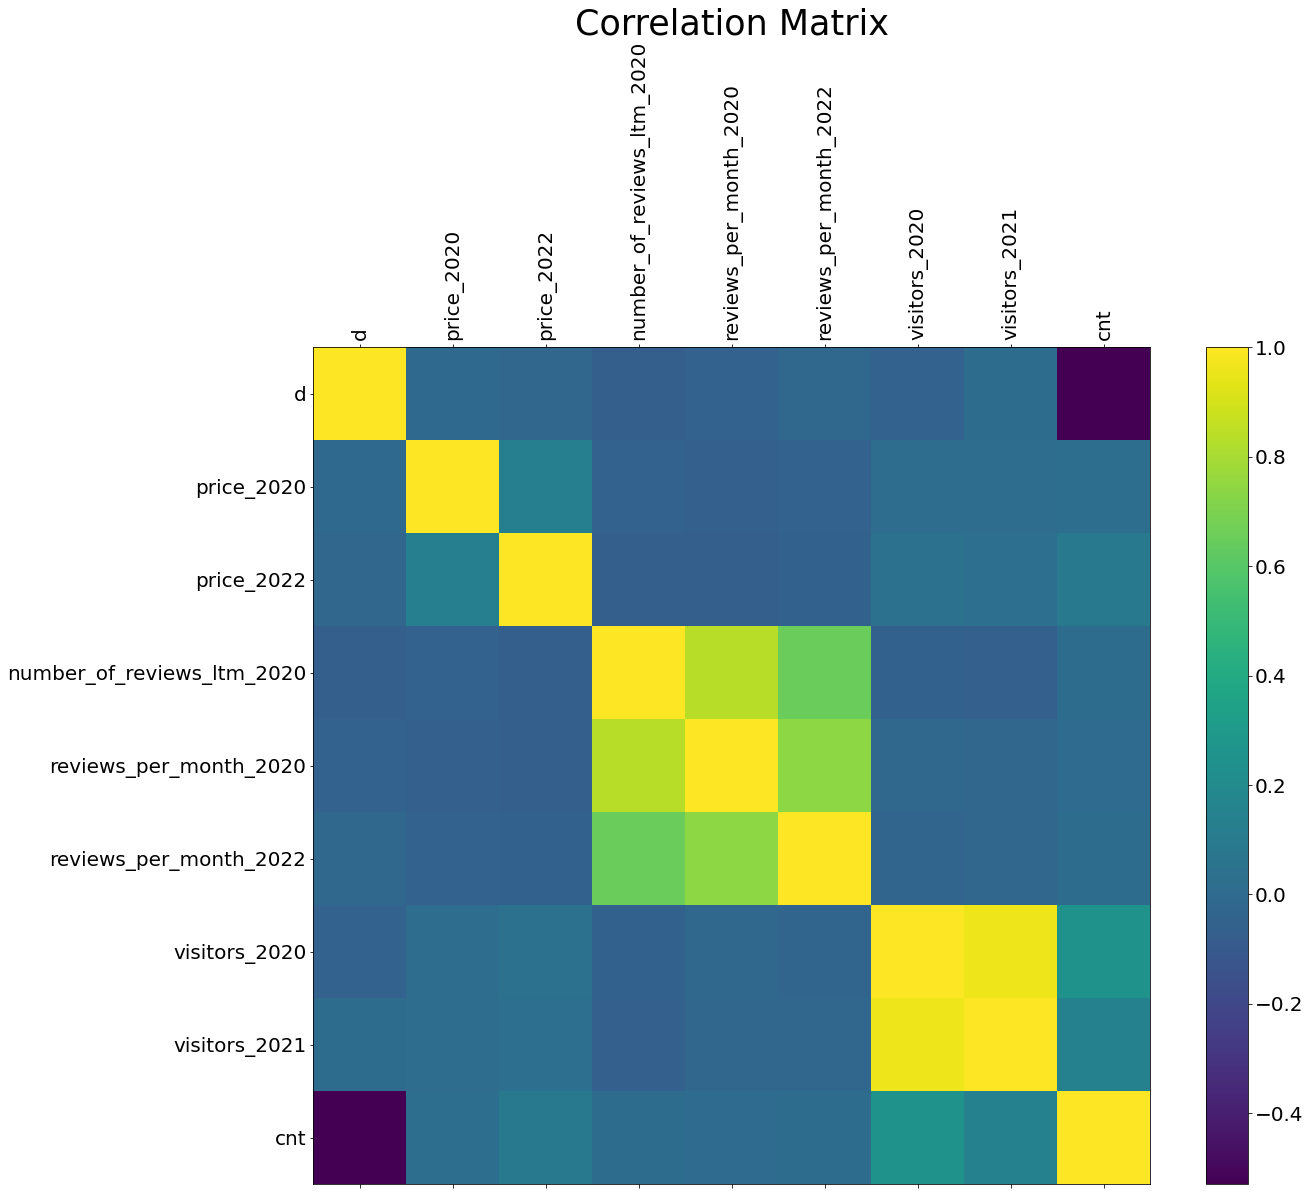

In [55]:
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(20, 15))
plt.matshow(df_standardised.corr(), fignum=f.number)
plt.xticks(range(df_standardised.shape[1]), df_standardised.columns, fontsize=20, rotation=90)
plt.yticks(range(df_standardised.shape[1]), df_standardised.columns, fontsize=20)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=20)
plt.title('Correlation Matrix', fontsize=35)

In [56]:
# delete inf and nan
df_standardised[np.isnan(df_standardised)] = 0
df_standardised[np.isinf(df_standardised)] = 0

In [59]:
# This performs a multiple regression of expectancy against recycling:

reg_visitors_2021 = smf.ols(formula='visitors_2021 ~ d + price_2020 + price_2022 + number_of_reviews_ltm_2020 + reviews_per_month_2020 +reviews_per_month_2022 + visitors_2020 + cnt',data=df_standardised).fit()

# And this gives a big summary of the results:
print(reg_visitors_2021.summary())

                            OLS Regression Results                            
Dep. Variable:          visitors_2021   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     8042.
Date:                Sat, 14 Jan 2023   Prob (F-statistic):               0.00
Time:                        16:13:02   Log-Likelihood:                 6655.5
No. Observations:                4441   AIC:                        -1.329e+04
Df Residuals:                    4432   BIC:                        -1.324e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           